In [1]:
from prophet import Prophet
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from prophet.diagnostics import performance_metrics
from prophet.serialize import model_to_json, model_from_json
import seaborn as sns
import matplotlib.pyplot as plt
from prophet.serialize import model_to_json, model_from_json
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import json
import os

In [2]:
import logging
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

In [3]:
#https://www.kaggle.com/competitions/m5-forecasting-accuracy

# Load sales data
sales = pd.read_csv('/home/ianli/homl-self/walmart/data/sales_train_validation.csv')  
calendar = pd.read_csv('/home/ianli/homl-self/walmart/data/calendar.csv')
sell_prices = pd.read_csv('/home/ianli/homl-self/walmart/data/sell_prices.csv')

In [4]:
sales.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd_1',
       'd_2', 'd_3', 'd_4',
       ...
       'd_1904', 'd_1905', 'd_1906', 'd_1907', 'd_1908', 'd_1909', 'd_1910',
       'd_1911', 'd_1912', 'd_1913'],
      dtype='object', length=1919)

In [11]:
sell_prices.columns

Index(['store_id', 'item_id', 'wm_yr_wk', 'sell_price'], dtype='object')

In [12]:
calendar.columns

Index(['date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI'],
      dtype='object')

In [5]:
sales['dept_id'].value_counts()

dept_id
FOODS_3        8230
HOUSEHOLD_1    5320
HOUSEHOLD_2    5150
HOBBIES_1      4160
FOODS_2        3980
FOODS_1        2160
HOBBIES_2      1490
Name: count, dtype: int64

In [6]:
sales['store_id'].value_counts()

store_id
CA_1    3049
CA_2    3049
CA_3    3049
CA_4    3049
TX_1    3049
TX_2    3049
TX_3    3049
WI_1    3049
WI_2    3049
WI_3    3049
Name: count, dtype: int64

In [4]:
#look at dept, store breakdown
#  Melt sales data to long format for time series
sales_long = sales.melt(
    id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
    var_name="d",           #collapse all d variants into d
    value_name="sales"
)


In [6]:

#  Focus on one department in one store
sales_dept = sales_long[
    (sales_long["store_id"] == "CA_1") & 
    (sales_long["dept_id"] == "FOODS_3")
]

#  Aggregate sales per day for this dept store pair
dept_sales = sales_dept.groupby("d")["sales"].sum().reset_index()

#  Merge with calendar and add features
dept_sales = dept_sales.merge(
    calendar[["d", "date", "snap_CA", "event_name_1", "event_name_2"]],
    on="d", how="left"
)
dept_sales["ds"] = pd.to_datetime(dept_sales["date"])
dept_sales["y"] = dept_sales["sales"]
dept_sales["snap"] = dept_sales["snap_CA"]

#  Create holidays DataFrame from calendar and prep names recognised by prophet
events_1 = calendar[["date", "event_name_1"]].dropna().rename(columns={"event_name_1": "holiday"})
events_2 = calendar[["date", "event_name_2"]].dropna().rename(columns={"event_name_2": "holiday"})
holidays_df = pd.concat([events_1, events_2])
holidays_df = holidays_df.rename(columns={"date": "ds"})
holidays_df["ds"] = pd.to_datetime(holidays_df["ds"])
holidays_df["lower_window"] = -3
holidays_df["upper_window"] = 3

# Final dataset for Prophet 
df = dept_sales[["ds", "y", "snap"]].copy()


In [ ]:

# Sort data
df = df.sort_values("ds").reset_index(drop=True)

# Set rolling window sizes
train_days = 365 * 3
test_days = 30
start_idx = 0

# Store metrics and forecast from each fold
rolling_metrics = []
all_forecasts = []

while start_idx + train_days + test_days <= len(df):
    train = df.iloc[start_idx:start_idx + train_days].copy()
    test = df.iloc[start_idx + train_days:start_idx + train_days + test_days].copy()

    # Fit model
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        holidays=holidays_df
    )
    model.add_regressor("snap")
    model.fit(train)

    # Create future df for test period
    future = model.make_future_dataframe(periods=test_days)
    snap_lookup = df[["ds", "snap"]]
    future = future.merge(snap_lookup, on="ds", how="left")
    future["snap"] = future["snap"].ffill().fillna(0)

    # Forecast
    forecast = model.predict(future)
    fold_forecast = forecast[forecast['ds'].isin(test['ds'])][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    all_forecasts.append(fold_forecast)

    # Evaluate only on the test portion
    forecast_valid = pd.merge(
        forecast[['ds', 'yhat']], test[['ds', 'y']], on='ds', how='inner'
    )

    y_true = forecast_valid['y'].values
    y_pred = forecast_valid['yhat'].values

    # Compute metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mask = y_true > 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    r2 = r2_score(y_true, y_pred)

    rolling_metrics.append({
        'train_start': train['ds'].min(),
        'train_end': train['ds'].max(),
        'test_start': test['ds'].min(),
        'test_end': test['ds'].max(),
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'r2': r2
    })

    start_idx += test_days  # move window forward by test period size



19:01:50 - cmdstanpy - INFO - Chain [1] start processing
19:01:51 - cmdstanpy - INFO - Chain [1] done processing
19:01:51 - cmdstanpy - INFO - Chain [1] start processing
19:01:51 - cmdstanpy - INFO - Chain [1] done processing
19:01:52 - cmdstanpy - INFO - Chain [1] start processing
19:01:52 - cmdstanpy - INFO - Chain [1] done processing
19:01:52 - cmdstanpy - INFO - Chain [1] start processing
19:01:52 - cmdstanpy - INFO - Chain [1] done processing
19:01:53 - cmdstanpy - INFO - Chain [1] start processing
19:01:53 - cmdstanpy - INFO - Chain [1] done processing
19:01:53 - cmdstanpy - INFO - Chain [1] start processing
19:01:54 - cmdstanpy - INFO - Chain [1] done processing
19:01:54 - cmdstanpy - INFO - Chain [1] start processing
19:01:54 - cmdstanpy - INFO - Chain [1] done processing
19:01:54 - cmdstanpy - INFO - Chain [1] start processing
19:01:55 - cmdstanpy - INFO - Chain [1] done processing
19:01:55 - cmdstanpy - INFO - Chain [1] start processing
19:01:55 - cmdstanpy - INFO - Chain [1]

In [8]:
# View summary
cv_results = pd.DataFrame(rolling_metrics)
print(cv_results[['rmse', 'mae', 'mape', 'r2']].describe())

             rmse         mae       mape         r2
count   27.000000   27.000000  27.000000  27.000000
mean   233.087509  189.179883   9.123765   0.721972
std     60.306938   53.490638   2.600674   0.192523
min    144.065389  104.303068   4.732034   0.037588
25%    192.564779  152.178400   7.052763   0.637259
50%    221.379158  180.256795   8.611075   0.784538
75%    275.866411  227.992882  10.828858   0.854478
max    345.232838  323.857033  16.574217   0.904136


<div class="alert alert-block alert-info">
investigations on irregular metrics

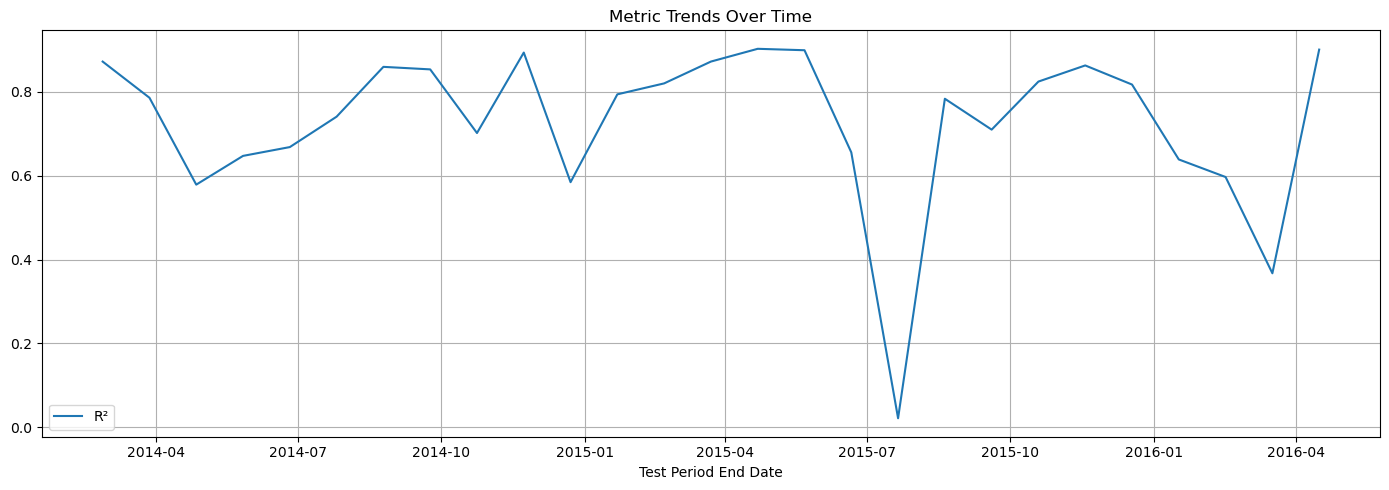

In [63]:
metrics_df['test_end'] = pd.to_datetime(metrics_df['test_end'])
metrics_df = metrics_df.sort_values('test_end')

plt.figure(figsize=(14, 5))
#plt.plot(metrics_df['test_end'], metrics_df['mape'], label='MAPE')
plt.plot(metrics_df['test_end'], metrics_df['r2'], label='R²')
plt.title("Metric Trends Over Time")
plt.xlabel("Test Period End Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [64]:
metrics_df[(metrics_df['r2'] < 0.2)]

,train_start,train_end,test_start,test_end,rmse,mae,mape,r2
17,2012-06-22,2015-06-21,2015-06-22,2015-07-21,342.693825,259.982035,11.92521,0.021184


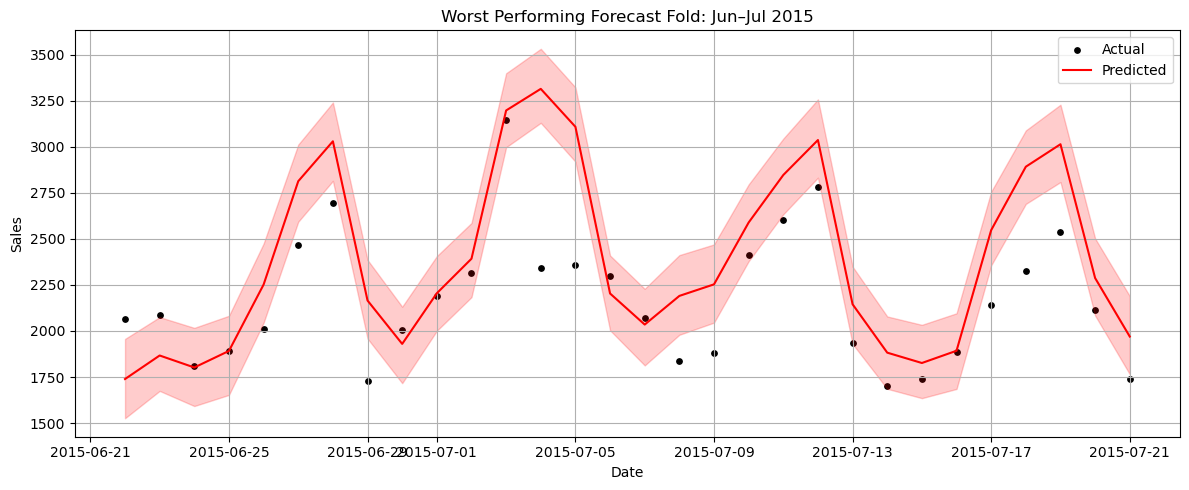

In [65]:
worst_forecast = all_forecasts[17]

# Find actual values from df
actual_worst = df[(df['ds'] >= "2015-06-22") & (df['ds'] <= "2015-07-21")]

plt.figure(figsize=(12, 5))
plt.scatter(actual_worst['ds'], actual_worst['y'], label='Actual', color='black', s=15)
plt.plot(worst_forecast['ds'], worst_forecast['yhat'], label='Predicted', color='red')
plt.fill_between(
    worst_forecast['ds'],
    worst_forecast['yhat_lower'],
    worst_forecast['yhat_upper'],
    color='red', alpha=0.2
)
plt.title("Worst Performing Forecast Fold: Jun–Jul 2015")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
calendar[(calendar['date'] >= '2015-06-22') & (calendar['date'] <= '2015-07-21')][['date', 'event_name_1', 'snap_CA']]

,date,event_name_1,snap_CA
1605,2015-06-22,NaN,0
1606,2015-06-23,NaN,0
1607,2015-06-24,NaN,0
1608,2015-06-25,NaN,0
1609,2015-06-26,NaN,0
1610,2015-06-27,NaN,0
1611,2015-06-28,NaN,0
1612,2015-06-29,NaN,0
1613,2015-06-30,NaN,0
1614,2015-07-01,NaN,1


During time-based CV, observed a sharp drop in R² in July 2015. Analysis revealed a rare pattern: 10 consecutive SNAP days and overlapping holidays (Independence Day and Eid al-Fitr). 

While Eid al-Fitr holidays were already included in the model's holiday features, the sharp dip in R² during July 2015 was driven by an unusual and rare combination of multiple factors: 

a long sequence of SNAP days overlapping with both Independence Day and Eid al-Fitr. 

This created a complex pattern of demand shifts that the additive holiday model in Prophet struggled to generalize to, as such joint patterns were scarce or unseen during training. 


In [40]:
eid_events_1 = calendar[calendar['event_name_1'].str.contains('Eid', case=False, na=False)]
eid_events_2 = calendar[calendar['event_name_2'].str.contains('Eid', case=False, na=False)]

print(eid_events_1[['date', 'event_name_1']])
print(eid_events_2[['date', 'event_name_2']])

            date event_name_1
214   2011-08-31  Eid al-Fitr
282   2011-11-07    EidAlAdha
568   2012-08-19  Eid al-Fitr
636   2012-10-26    EidAlAdha
922   2013-08-08  Eid al-Fitr
990   2013-10-15    EidAlAdha
1277  2014-07-29  Eid al-Fitr
1344  2014-10-04    EidAlAdha
1631  2015-07-18  Eid al-Fitr
1699  2015-09-24    EidAlAdha
Empty DataFrame
Columns: [date, event_name_2]
Index: []


<div class="alert alert-block alert-info">
attempts to investigate snap and holiday interactions

In [50]:
calendar['is_holiday'] = calendar[['event_name_1', 'event_name_2']].notna().any(axis=1).astype(int)
calendar['snap'] = calendar['snap_CA'].fillna(0).astype(int)

# Interaction flag
calendar['snap_and_holiday'] = (calendar['snap'] & calendar['is_holiday']).astype(int)

# Count total co-occurrences
snap_holiday_count = calendar['snap_and_holiday'].sum()
print(f"Total days with SNAP and holiday: {snap_holiday_count}")

# Breakdown by holiday type
calendar['holiday_name'] = calendar['event_name_1'].fillna('') + calendar['event_name_2'].fillna('')
calendar.loc[calendar['holiday_name'] == '', 'holiday_name'] = 'None'

# Filter to days with both SNAP + Holiday
interactions = calendar[calendar['snap_and_holiday'] == 1]

# Count by holiday
print(interactions['holiday_name'].value_counts())

Total days with SNAP and holiday: 57
holiday_name
SuperBowl                      6
IndependenceDay                5
OrthodoxChristmas              5
LaborDay                       5
NewYear                        5
Cinco De Mayo                  5
NBAFinalsStart                 4
Ramadan starts                 3
Mother's day                   3
LentStart                      3
ColumbusDay                    2
EidAlAdha                      2
Purim End                      2
Easter                         2
Pesach End                     1
OrthodoxEasterCinco De Mayo    1
Eid al-Fitr                    1
Chanukah End                   1
OrthodoxEaster                 1
Name: count, dtype: int64


In [66]:

# Define snap column and holiday columns
snap_col = "snap_CA"
holiday_cols = ["event_name_1", "event_name_2"]

# Get holidays with enough SNAP interaction occurrences
snap_holiday_df = calendar[
    (calendar[snap_col] == 1) & 
    (calendar[holiday_cols[0]].notna() | calendar[holiday_cols[1]].notna())
]

# Count occurrences for holidays from event_name_1 and event_name_2
snap_holiday_counts_1 = snap_holiday_df[holiday_cols[0]].value_counts()
snap_holiday_counts_2 = snap_holiday_df[holiday_cols[1]].value_counts()

# Combine counts (fill missing with 0)
snap_holiday_counts = snap_holiday_counts_1.add(snap_holiday_counts_2, fill_value=0)

MIN_OCCURRENCE = 3
eligible_holidays = snap_holiday_counts[snap_holiday_counts >= MIN_OCCURRENCE].index.tolist()

print("Eligible SNAP-holiday interactions:", eligible_holidays)

Eligible SNAP-holiday interactions: ['Cinco De Mayo', 'IndependenceDay', 'LaborDay', 'LentStart', "Mother's day", 'NBAFinalsStart', 'NewYear', 'OrthodoxChristmas', 'Ramadan starts', 'SuperBowl']


In [67]:
# Create interaction column in dept_sales (1 if snap==1 AND holiday in eligible list)
def snap_holiday_interaction(row):
    is_snap = row[snap_col] == 1
    is_eligible_holiday = False
    for col in holiday_cols:
        if pd.notna(row[col]) and row[col] in eligible_holidays:
            is_eligible_holiday = True
            break
    return int(is_snap and is_eligible_holiday)

dept_sales['snap_holiday_interaction'] = dept_sales.apply(snap_holiday_interaction, axis=1)

# Prepare final df for Prophet, add interaction regressor
df = dept_sales[["ds", "y", "snap_CA", "snap_holiday_interaction"]].copy()
df = df.rename(columns={"snap_CA": "snap"})
df = df.sort_values("ds").reset_index(drop=True)

# Prepare holidays dataframe for Prophet
events_1 = calendar[["date", "event_name_1"]].dropna().rename(columns={"event_name_1": "holiday"})
events_2 = calendar[["date", "event_name_2"]].dropna().rename(columns={"event_name_2": "holiday"})
holidays_df = pd.concat([events_1, events_2])
holidays_df = holidays_df.rename(columns={"date": "ds"})
holidays_df["ds"] = pd.to_datetime(holidays_df["ds"])
holidays_df["lower_window"] = -3
holidays_df["upper_window"] = 3

In [68]:
# Rolling CV parameters
train_days = 365 * 3
test_days = 30
start_idx = 0

rolling_metrics = []
all_forecasts = []

while start_idx + train_days + test_days <= len(df):
    train = df.iloc[start_idx:start_idx + train_days].copy()
    test = df.iloc[start_idx + train_days:start_idx + train_days + test_days].copy()

    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        holidays=holidays_df
    )
    model.add_regressor("snap")
    model.add_regressor("snap_holiday_interaction")

    model.fit(train)

    future = model.make_future_dataframe(periods=test_days)
    # Merge snap and interaction regressor into future dataframe
    future = future.merge(df[["ds", "snap", "snap_holiday_interaction"]], on="ds", how="left")
    # Fill missing values (forward fill, then 0)
    future["snap"] = future["snap"].fillna(method="ffill").fillna(0)
    future["snap_holiday_interaction"] = future["snap_holiday_interaction"].fillna(method="ffill").fillna(0)

    forecast = model.predict(future)
    fold_forecast = forecast[forecast['ds'].isin(test['ds'])][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    all_forecasts.append(fold_forecast)

    forecast_valid = pd.merge(
        forecast[['ds', 'yhat']], test[['ds', 'y']], on='ds', how='inner'
    )
    y_true = forecast_valid['y'].values
    y_pred = forecast_valid['yhat'].values

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mask = y_true > 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    r2 = r2_score(y_true, y_pred)

    rolling_metrics.append({
        'train_start': train['ds'].min(),
        'train_end': train['ds'].max(),
        'test_start': test['ds'].min(),
        'test_end': test['ds'].max(),
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'r2': r2
    })

    start_idx += test_days

14:29:47 - cmdstanpy - INFO - Chain [1] start processing
14:29:47 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_5810/1633225989.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future["snap"] = future["snap"].fillna(method="ffill").fillna(0)
/tmp/ipykernel_5810/1633225989.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future["snap_holiday_interaction"] = future["snap_holiday_interaction"].fillna(method="ffill").fillna(0)
14:29:48 - cmdstanpy - INFO - Chain [1] start processing
14:29:48 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_5810/1633225989.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future["snap"] = future["snap"].fillna(method="ffill").fillna(0)
/tmp/ipykernel_5810/

             rmse         mae       mape         r2
count   27.000000   27.000000  27.000000  27.000000
mean   233.764281  188.993909   9.092979   0.718568
std     60.001734   53.057467   2.577247   0.197241
min    150.724936  115.842656   5.193901   0.013825
25%    189.581118  151.482201   7.145886   0.644199
50%    222.871129  177.560797   8.643655   0.797123
75%    278.788386  228.090877  10.696898   0.858303
max    345.960648  324.585840  16.611919   0.903062


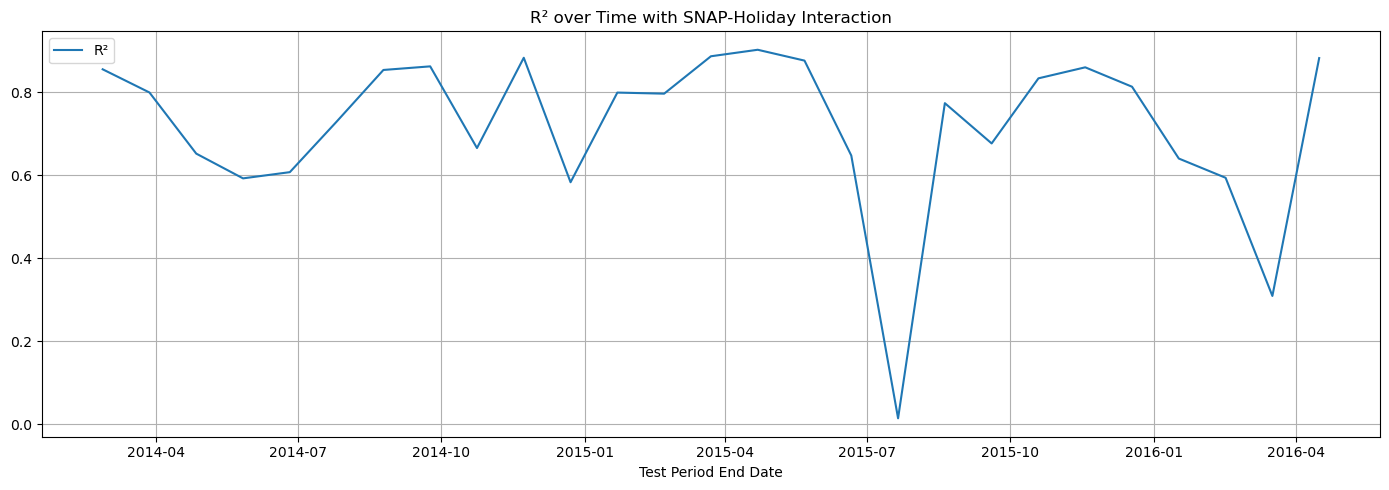

In [69]:
cv_results = pd.DataFrame(rolling_metrics)
print(cv_results[['rmse', 'mae', 'mape', 'r2']].describe())

# Plot R² over time
cv_results['test_end'] = pd.to_datetime(cv_results['test_end'])
cv_results = cv_results.sort_values('test_end')

plt.figure(figsize=(14, 5))
plt.plot(cv_results['test_end'], cv_results['r2'], label='R²')
plt.title("R² over Time with SNAP-Holiday Interaction")
plt.xlabel("Test Period End Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In July 2015, a rare pattern emerged: 10 consecutive SNAP days overlapped with major holidays, including Independence Day and Eid al-Fitr.

Aprroach:

Created an interaction variable for days with both SNAP and eligible holidays (those occurring more than 3 times).

Added this as an external regressor to the Prophet model.

Re-ran rolling time-based cross-validation (3-year train, 30-day test).

Observations:

r2 and min r2 decreased instead in attempts to take into account holidays and snap occuring together. 

this indicates that the interaction added noise rather than predictive value.

Moreover, sales during periods like July 2015 — when 10 SNAP days overlapped with holidays — did not show unusual spikes. 

They remained close to the mean, and Prophet was likely already generalizing well without explicit encoding of this feature.

<div class="alert alert-block alert-info">
plots

In [ ]:
# Final model: train on latest available data
final_train = df.iloc[-train_days:].copy()  # last 3 years
final_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    holidays=holidays_df
)
final_model.add_regressor("snap")
final_model.fit(final_train)

# Forecast into the future 
future_final = final_model.make_future_dataframe(periods=test_days)

# Add SNAP values for future dates
# Option 1: Use same SNAP values as same weekday last year
snap_lookup = df[["ds", "snap"]].copy()
snap_lookup["dow"] = snap_lookup["ds"].dt.dayofweek
future_final["dow"] = future_final["ds"].dt.dayofweek
future_final = future_final.merge(
    snap_lookup[["dow", "snap"]].drop_duplicates(),
    on="dow", how="left"
)
future_final.drop(columns="dow", inplace=True)

# Forecast
forecast_final = final_model.predict(future_final)

17:29:44 - cmdstanpy - INFO - Chain [1] start processing
17:29:44 - cmdstanpy - INFO - Chain [1] done processing


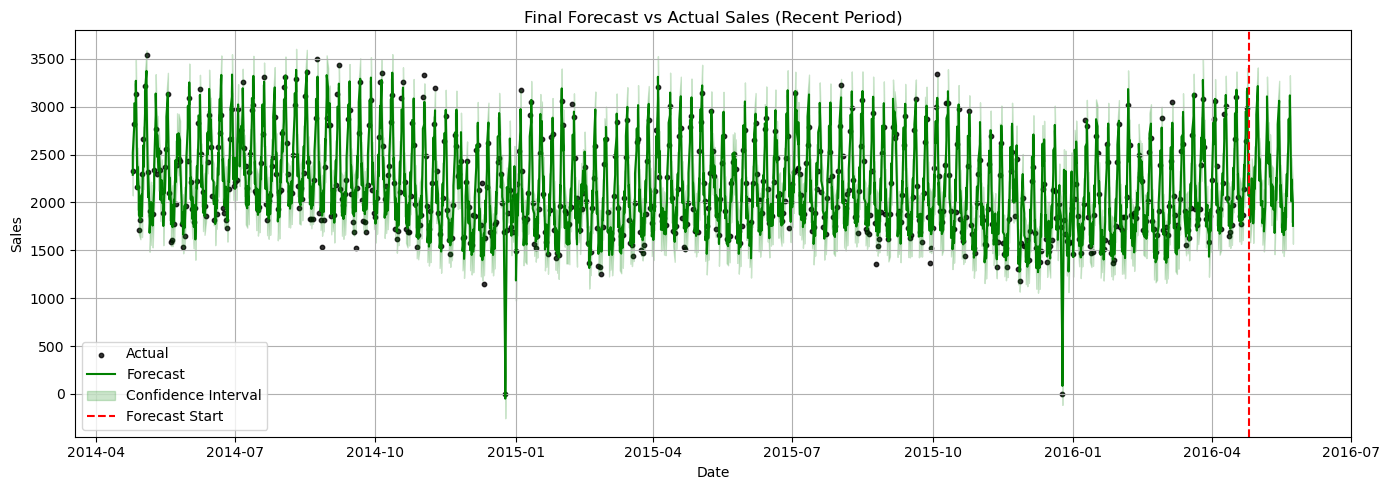

In [26]:
# Show only relevant dates (last 2 years of history + forecast)
plot_start_date = df['ds'].max() - pd.Timedelta(days=730)
df_trimmed = df[df['ds'] >= plot_start_date].copy()
forecast_final_trimmed = forecast_final[forecast_final['ds'] >= plot_start_date].copy()

# Plot
plt.figure(figsize=(14, 5))

# Actuals
plt.scatter(df_trimmed['ds'], df_trimmed['y'], label='Actual', color='black', alpha=0.8, s=10)

# Final forecast
plt.plot(forecast_final_trimmed['ds'], forecast_final_trimmed['yhat'], label='Forecast', color='green')
plt.fill_between(
    forecast_final_trimmed['ds'],
    forecast_final_trimmed['yhat_lower'],
    forecast_final_trimmed['yhat_upper'],
    color='green', alpha=0.2, label='Confidence Interval'
)

# Red dashed line: forecast start
prediction_start_date = df['ds'].max() + pd.Timedelta(days=1)
plt.axvline(prediction_start_date, color='red', linestyle='--', label='Forecast Start')

plt.title("Final Forecast vs Actual Sales (Recent Period)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

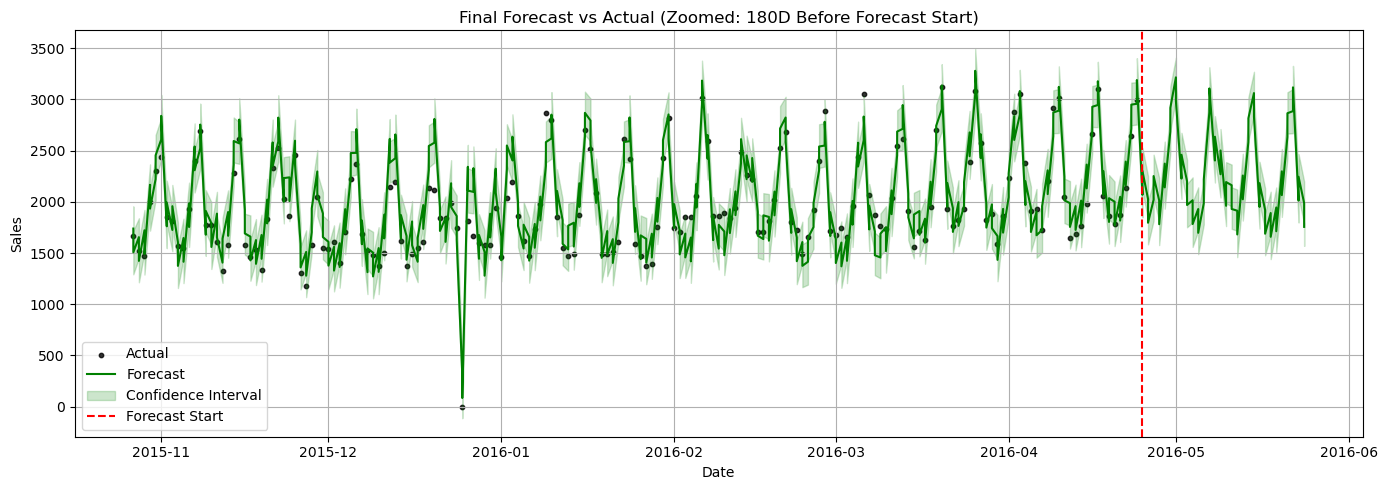

In [40]:
# Define key dates
prediction_start_date = df['ds'].max() + pd.Timedelta(days=1)
zoom_start_date = df['ds'].max() - pd.Timedelta(days=180)
zoom_end_date = forecast_final['ds'].max()

# Filter actuals and forecasts within this window
df_zoom = df[(df['ds'] >= zoom_start_date) & (df['ds'] <= zoom_end_date)].copy()
forecast_zoom = forecast_final[(forecast_final['ds'] >= zoom_start_date) & (forecast_final['ds'] <= zoom_end_date)].copy()

# Plot
plt.figure(figsize=(14, 5))

# Actual sales (1 year before prediction)
plt.scatter(df_zoom['ds'], df_zoom['y'], label='Actual', color='black', alpha=0.8, s=10)

# Final forecast
plt.plot(forecast_zoom['ds'], forecast_zoom['yhat'], label='Forecast', color='green')
plt.fill_between(
    forecast_zoom['ds'],
    forecast_zoom['yhat_lower'],
    forecast_zoom['yhat_upper'],
    color='green', alpha=0.2, label='Confidence Interval'
)

# Red vertical line at start of forecast
plt.axvline(prediction_start_date, color='red', linestyle='--', label='Forecast Start')

plt.title("Final Forecast vs Actual (Zoomed: 180D Before Forecast Start)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/home/ianli/anaconda3/envs/timeseries_env/lib/python3.10/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/home/ianli/anaconda3/envs/timeseries_env/lib/python3.10/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name + '_lower'],
/home/ianli/anaconda3/envs/timeseries_env/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Se

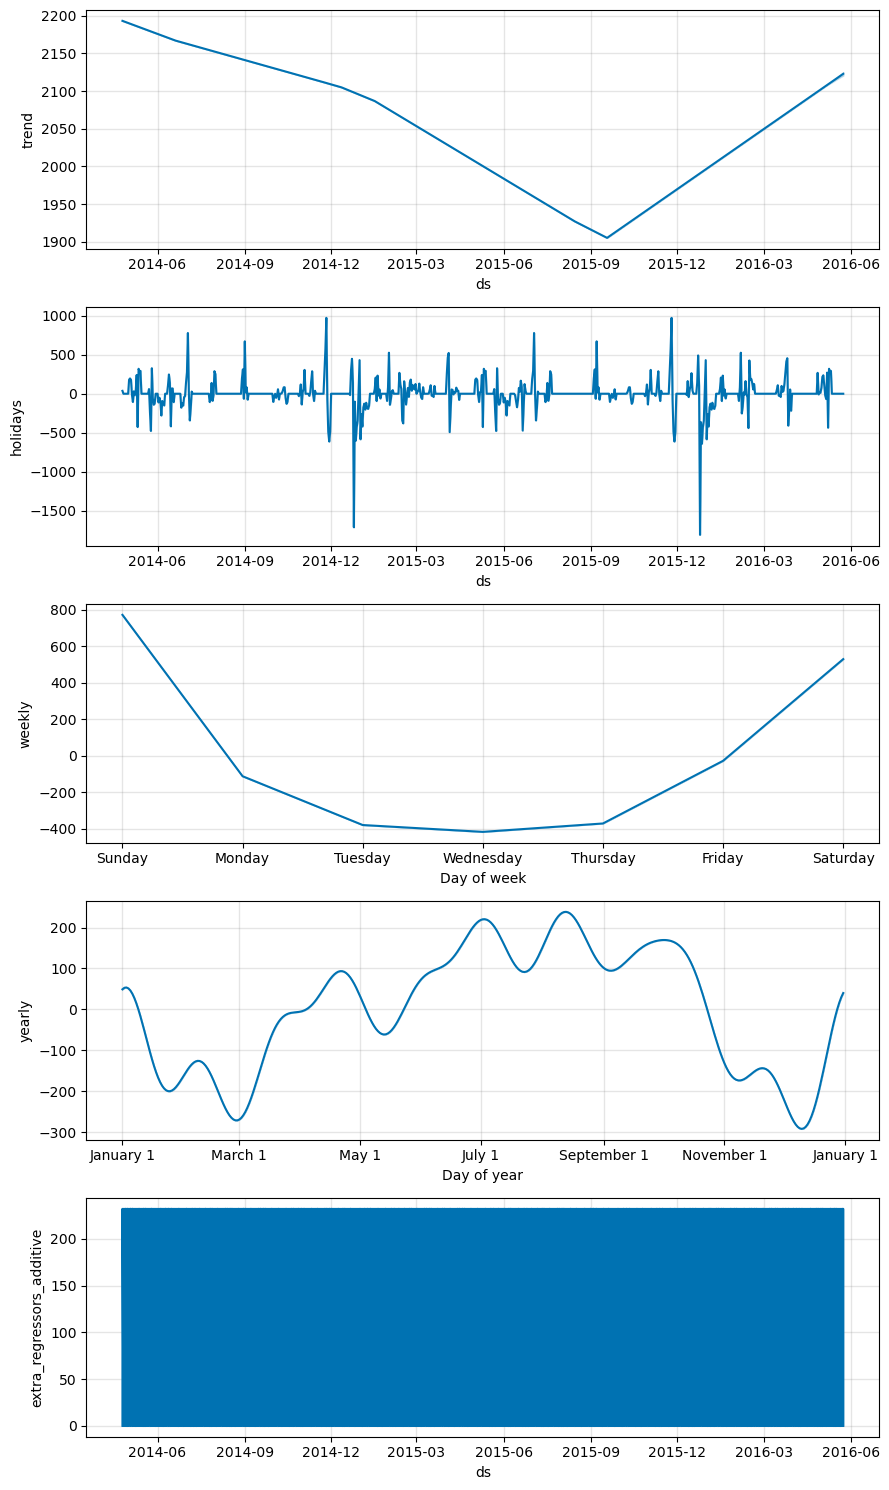

In [41]:
# Plot Prophet components (trend, yearly, weekly, holidays)
fig = final_model.plot_components(forecast_final)
plt.tight_layout()
plt.show()

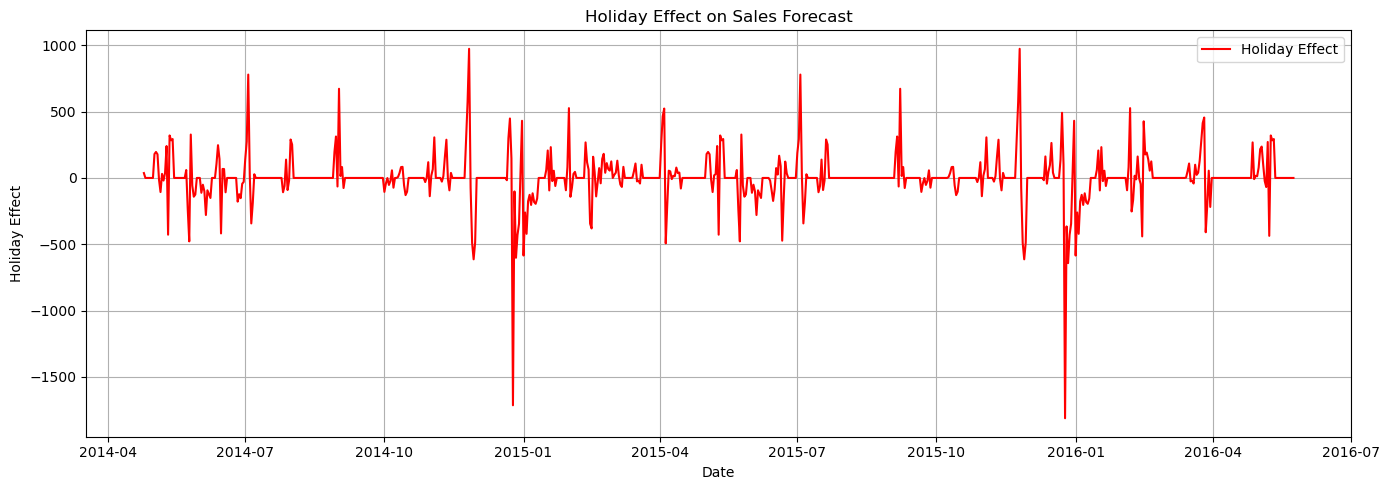

In [42]:
plt.figure(figsize=(14,5))
plt.plot(forecast_final['ds'], forecast_final['holidays'], label='Holiday Effect', color='red')
plt.title("Holiday Effect on Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Holiday Effect")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

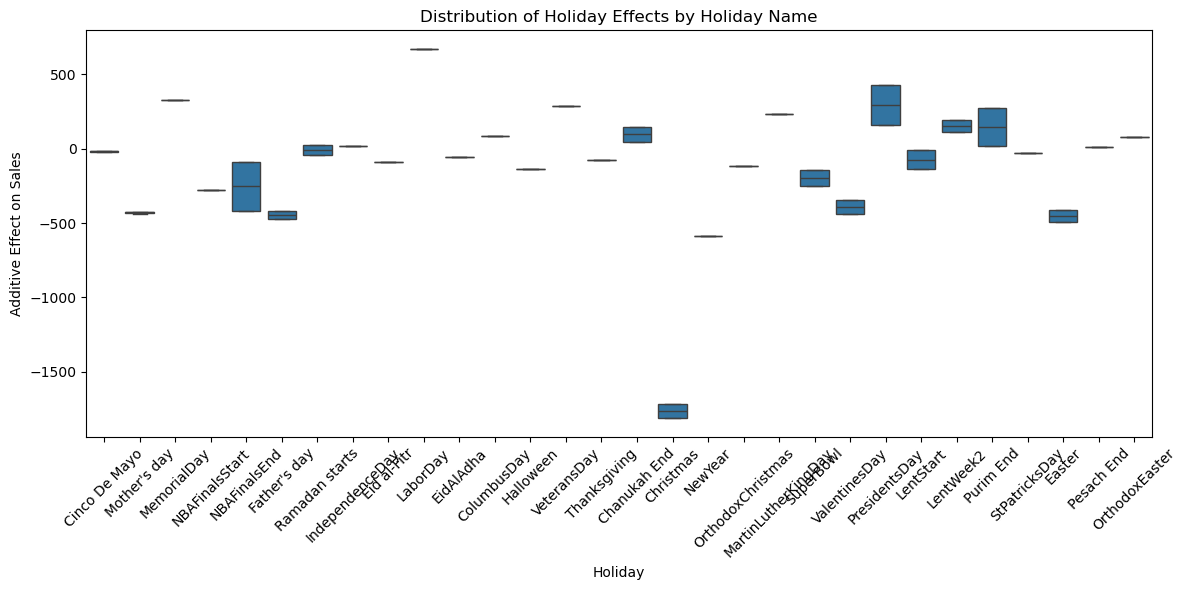

In [43]:
holiday_effects = forecast_final[['ds', 'holidays']].merge(
    holidays_df[['ds', 'holiday']], on='ds', how='inner'
)

import seaborn as sns
plt.figure(figsize=(12,6))
sns.boxplot(data=holiday_effects, x='holiday', y='holidays')
plt.xticks(rotation=45)
plt.title("Distribution of Holiday Effects by Holiday Name")
plt.ylabel("Additive Effect on Sales")
plt.xlabel("Holiday")
plt.tight_layout()
plt.show()

For holidays, labor day seems to have the biggest positive impact on this dept store pair combination

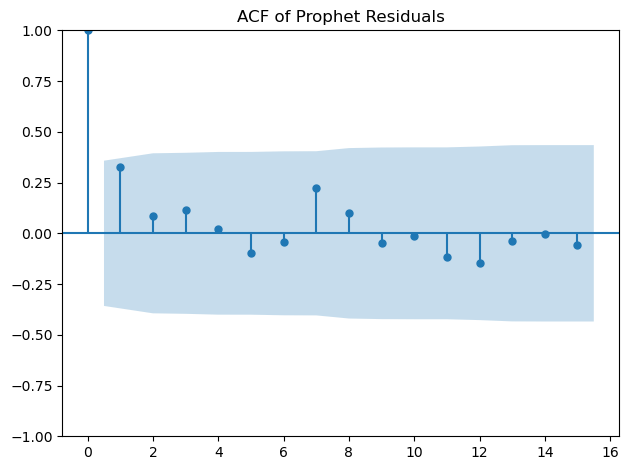

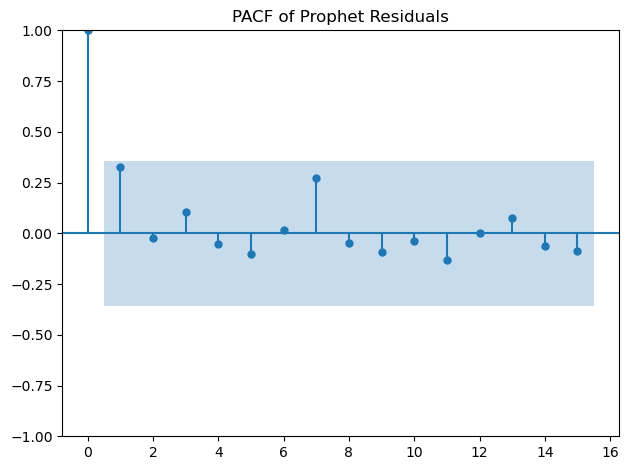

In [48]:

# Clean residuals
residuals = forecast_valid['y'] - forecast_valid['yhat']
residuals = residuals.replace([np.inf, -np.inf], np.nan).dropna()

# Plot ACF
plot_acf(residuals)
plt.title("ACF of Prophet Residuals")
plt.tight_layout()
plt.show()

# Plot PACF
plot_pacf(residuals)
plt.title("PACF of Prophet Residuals")
plt.tight_layout()
plt.show()




<div class="alert alert-block alert-info">
temporal time split approach

In [109]:
# Step: Introduce cutoff date for temporal train-test split
cutoff_date = df['ds'].max() - pd.Timedelta(days=30)

train_df = df[df['ds'] <= cutoff_date].copy()
test_df = df[df['ds'] > cutoff_date].copy()

In [110]:
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    holidays=holidays_df
)
model.add_regressor("snap")

model.fit(train_df)

20:49:11 - cmdstanpy - INFO - Chain [1] start processing
20:49:12 - cmdstanpy - INFO - Chain [1] done processing


In [126]:
future_periods = 30
#future = model.make_future_dataframe(periods=future_periods)
future_dates = pd.date_range(start=df['ds'].max() + pd.Timedelta(days=1), periods=future_periods, freq='D')
future = pd.concat([df[['ds']], future_dates.to_frame(name='ds')], ignore_index=True)

# Combine train and future for full forecast
future = pd.concat([train_df[['ds']], future], ignore_index=True)
#assume no snap or holiday for forecast
# Build SNAP mapping from previous year
snap_map = calendar[["date", "snap_CA"]].copy()
snap_map["date"] = pd.to_datetime(snap_map["date"])
snap_map["date_next_year"] = snap_map["date"] + pd.DateOffset(years=1)

# Map next year's SNAP onto current future period
snap_lookup = snap_map[["date_next_year", "snap_CA"]].rename(columns={"date_next_year": "ds"})
future = future.merge(snap_lookup, on="ds", how="left")

# Fallback to 0 or ffill if missing
future["snap"] = future["snap_CA"].fillna(method='ffill').fillna(0)
future.drop(columns=["snap_CA"], inplace=True)

#  Make forecast

forecast = model.predict(future)


/tmp/ipykernel_64317/3247454910.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future["snap"] = future["snap_CA"].fillna(method='ffill').fillna(0)


In [135]:

#  Merge forecast with actuals for evaluation
df_eval = pd.merge(forecast[['ds', 'yhat']], test_df[['ds', 'y']], on='ds', how='inner')
y_true = df_eval['y'].values
y_pred = df_eval['yhat'].values

#  Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
non_zero_mask = (np.abs(y_true) + np.abs(y_pred)) != 0

smape = 100 * np.mean(2 * np.abs(y_pred[non_zero_mask] - y_true[non_zero_mask]) /
                      (np.abs(y_true[non_zero_mask]) + np.abs(y_pred[non_zero_mask])))

mask = y_true > 0
mape = 100 * np.mean(
    np.abs((y_pred[mask] - y_true[mask]) / y_true[mask])
)
r2 = r2_score(y_true, y_pred)

print(f" RMSE:  {rmse:.2f}")
print(f" MAE:   {mae:.2f}")
print(f" SMAPE: {smape:.2f}%")
print(f" MAPE:  {mape:.2f}%")
print(f" R²:    {r2:.2f}")

 RMSE:  238.62
 MAE:   211.47
 SMAPE: 10.21%
 MAPE:  9.59%
 R²:    0.77


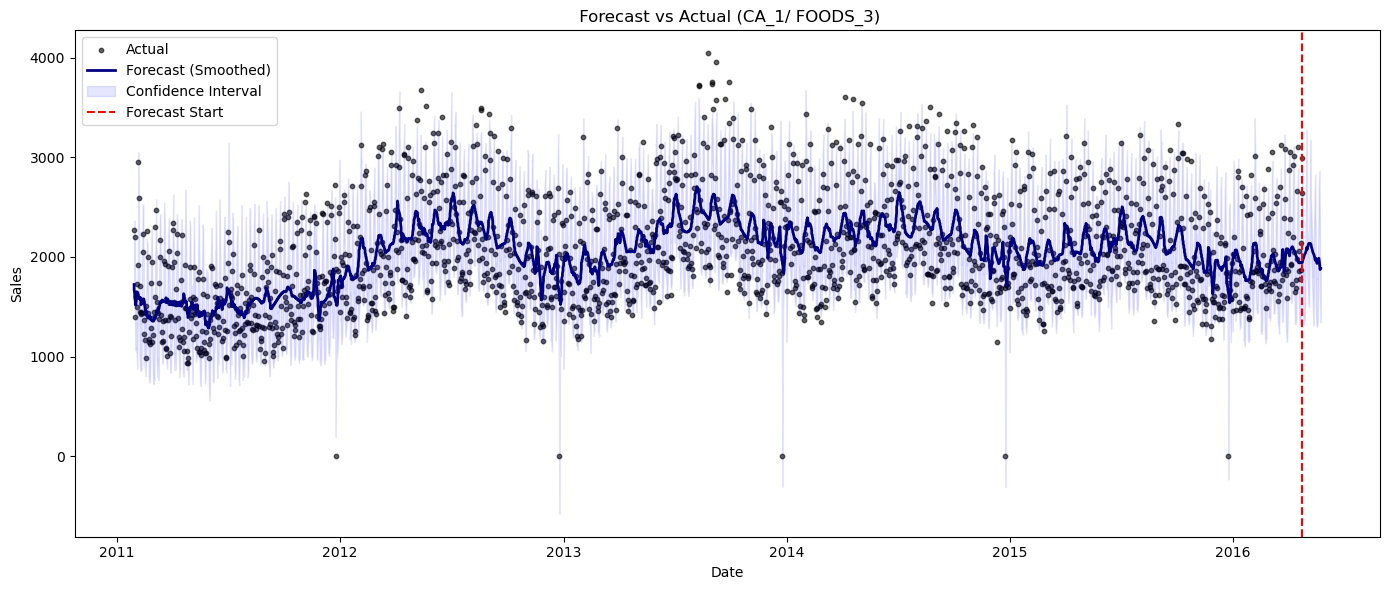

In [154]:
# --- Smooth forecast ---
forecast['yhat_smooth'] = forecast['yhat'].rolling(window=14, center=True, min_periods=1).mean()
smoothed_valid = forecast[['ds', 'yhat_smooth']].dropna()

# --- Plot ---
plt.figure(figsize=(14, 6))

# Plot actuals as dots only (no lines)
#plt.scatter(actual_valid['ds'], actual_valid['y_clean'], label='Actual', color='black', s=10, alpha=0.6)
plt.scatter(df['ds'], df['y'], label='Actual', color='black', s=10, alpha=0.6)

# Plot smoothed forecast line
plt.plot(smoothed_valid['ds'], smoothed_valid['yhat_smooth'], label='Forecast (Smoothed)', color='navy', linewidth=2)

# Confidence interval
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                 color='blue', alpha=0.1, label='Confidence Interval')

# Forecast start marker
plt.axvline(df['ds'].max(), color='red', linestyle='--', label='Forecast Start')

# Final styling
plt.title(" Forecast vs Actual (CA_1/ FOODS_3)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()


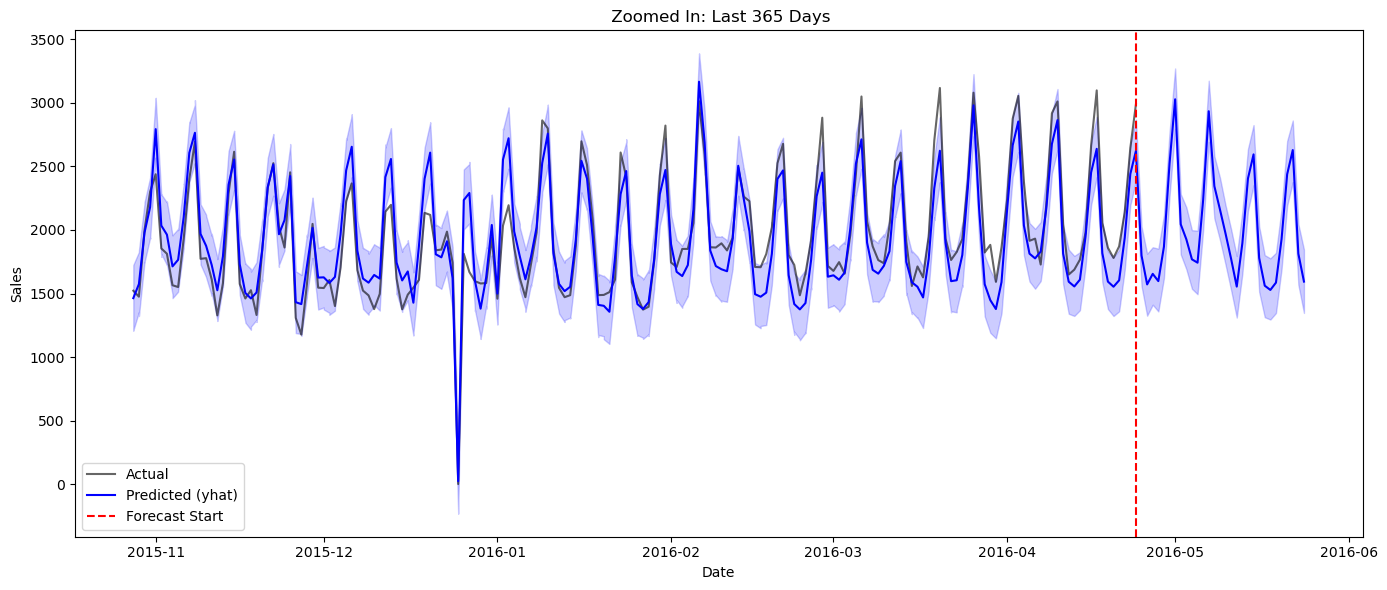

In [156]:
#Zoomed-In: Last 90 Days Before Forecast

zoom_df = df[df['ds'] > df['ds'].max() - pd.Timedelta(days=180)]
zoom_fc = forecast[forecast['ds'] > df['ds'].max() - pd.Timedelta(days=180)]

plt.figure(figsize=(14, 6))
plt.plot(zoom_df['ds'], zoom_df['y'], label='Actual', color='black', alpha=0.6)
plt.plot(zoom_fc['ds'], zoom_fc['yhat'], label='Predicted (yhat)', color='blue')
plt.fill_between(zoom_fc['ds'], zoom_fc['yhat_lower'], zoom_fc['yhat_upper'], color='blue', alpha=0.2)
plt.axvline(df['ds'].max(), color='red', linestyle='--', label='Forecast Start')
plt.title(' Zoomed In: Last 365 Days')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

/home/ianli/anaconda3/envs/timeseries_env/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/ianli/anaconda3/envs/timeseries_env/lib/python3.10/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/home/ianli/anaconda3/envs/timeseries_env/lib/python3.10/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing

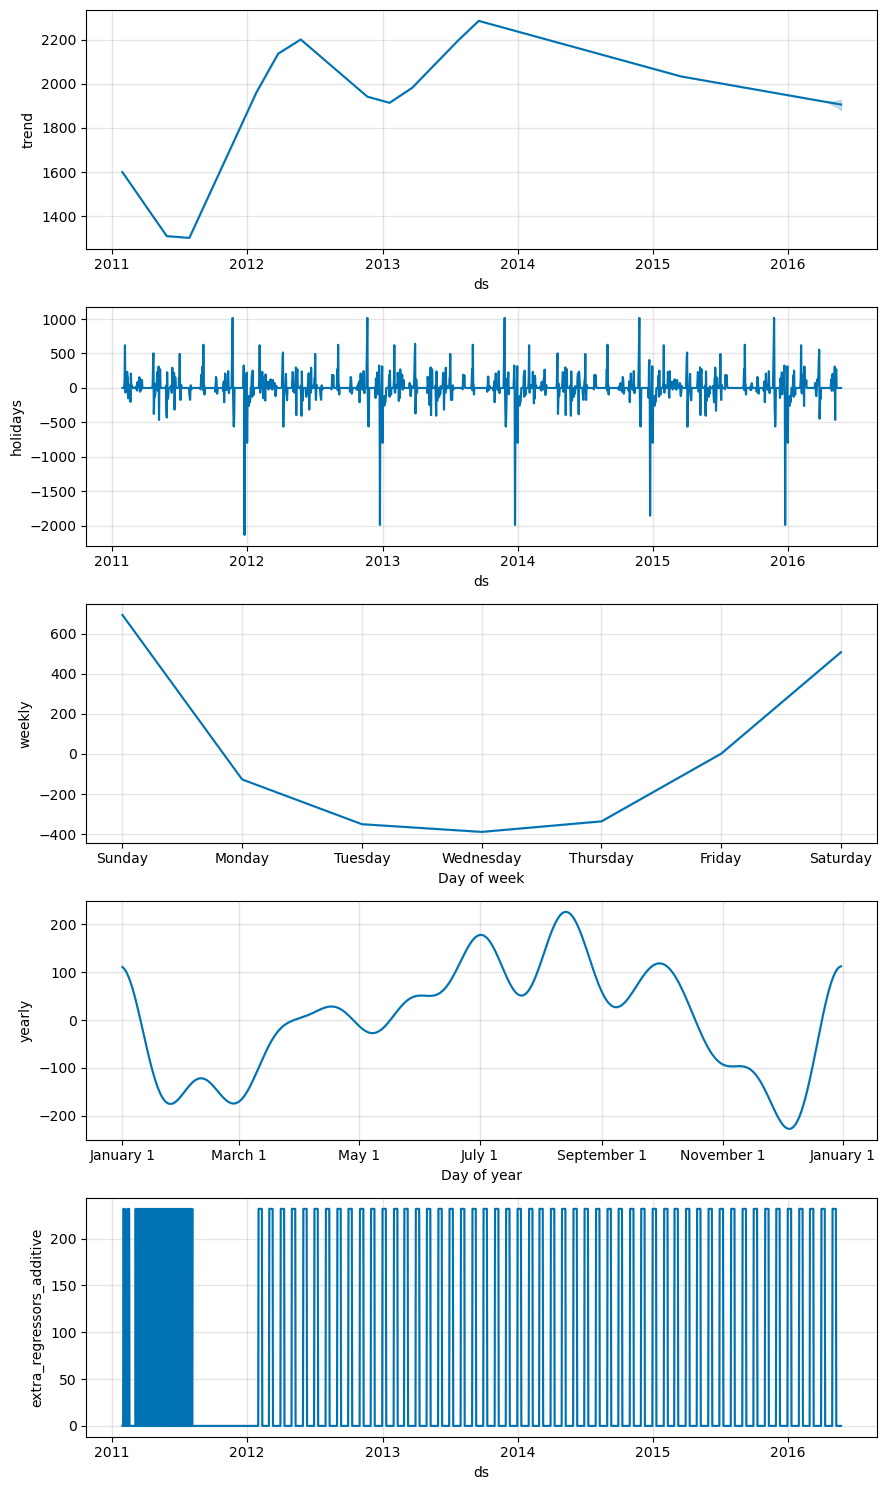

In [159]:
fig = model.plot_components(forecast)
fig.show()

temporal appproach is cleaner and simpler and has higher r2 based on initial look but rolling window can lead to more robust models over time

<div class="alert alert-block alert-info">
Generalise time series across all pairs

In [5]:

# --- 1. Prepare data ---
sales_long = sales.melt(
    id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
    var_name="d", value_name="sales"
)

total_sales = sales_long.groupby("d")["sales"].sum().reset_index()
total_sales = total_sales.merge(
    calendar[["d", "date", "snap_CA", "snap_TX", "snap_WI", "event_name_1", "event_name_2"]],
    on="d", how="left"
)
total_sales["ds"] = pd.to_datetime(total_sales["date"])
total_sales["y"] = total_sales["sales"]
total_sales["snap"] = total_sales[["snap_CA", "snap_TX", "snap_WI"]].max(axis=1).fillna(0)

df = total_sales[["ds", "y", "snap"]].sort_values("ds").reset_index(drop=True)

# --- 2. Holidays dataframe ---
events_1 = calendar[["date", "event_name_1"]].dropna().rename(columns={"event_name_1": "holiday"})
events_2 = calendar[["date", "event_name_2"]].dropna().rename(columns={"event_name_2": "holiday"})
holidays_df = pd.concat([events_1, events_2])
holidays_df = holidays_df.rename(columns={"date": "ds"})
holidays_df["ds"] = pd.to_datetime(holidays_df["ds"])
holidays_df["lower_window"] = -3
holidays_df["upper_window"] = 3

# --- 3. Temporal split ---
TEST_DAYS = 90
TRAIN_DAYS = 365 * 3

train = df.iloc[-(TRAIN_DAYS + TEST_DAYS):-TEST_DAYS].copy()
test = df.iloc[-TEST_DAYS:].copy()

In [6]:
# --- 4. Fit model ---
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    holidays=holidays_df
)
model.add_regressor("snap")
model.fit(train)

20:54:02 - cmdstanpy - INFO - Chain [1] start processing
20:54:02 - cmdstanpy - INFO - Chain [1] done processing


In [7]:

# --- 5. Forecast ---
FUTURE_DAYS = TEST_DAYS * 2  # Forecast 180 days to see extended horizon

future = model.make_future_dataframe(periods=FUTURE_DAYS)
snap_lookup = df[["ds", "snap"]]
future = future.merge(snap_lookup, on="ds", how="left")
future["snap"] = future["snap"].ffill().fillna(0)

forecast = model.predict(future)

In [8]:

# --- 6. Evaluation on test only ---
forecast_valid = pd.merge(forecast[["ds", "yhat"]], test[["ds", "y"]], on="ds", how="inner")
y_true = forecast_valid["y"].values
y_pred = forecast_valid["yhat"].values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%, R²: {r2:.4f}")



RMSE: 2592.79, MAE: 1970.07, MAPE: 4.43%, R²: 0.8562


In [11]:

# --- 7. Prepare plotting data ---
plot_df = forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].copy()
plot_df = plot_df.merge(df[["ds", "y"]], on="ds", how="left")

forecast_start = df["ds"].max() + pd.Timedelta(days=1)
start_date = forecast_start - pd.Timedelta(days=365)
end_date = forecast["ds"].max()  # full extended forecast horizon

plot_df = plot_df[plot_df["ds"].between(start_date, end_date)]

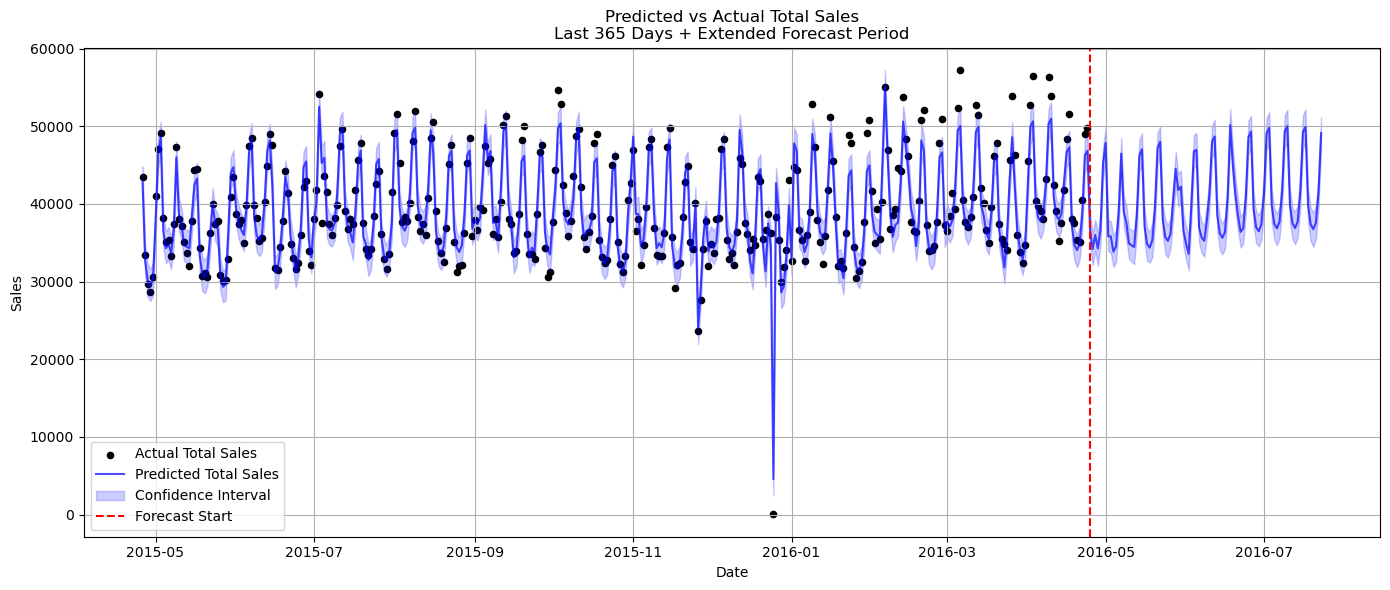

In [12]:

# --- 8. Plot ---
plt.figure(figsize=(14, 6))

# Actuals scatter only where available
plt.scatter(plot_df['ds'], plot_df['y'], label='Actual Total Sales', color='black', s=20)

# Forecast line
plt.plot(plot_df['ds'], plot_df['yhat'], label='Predicted Total Sales', color='blue', alpha=0.7)

# Confidence interval
plt.fill_between(plot_df['ds'], plot_df['yhat_lower'], plot_df['yhat_upper'],
                 color='blue', alpha=0.2, label='Confidence Interval')

# Red line: forecast start (training end + 1 day)
plt.axvline(x=forecast_start, color='red', linestyle='--', label='Forecast Start')

plt.title('Predicted vs Actual Total Sales\nLast 365 Days + Extended Forecast Period')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

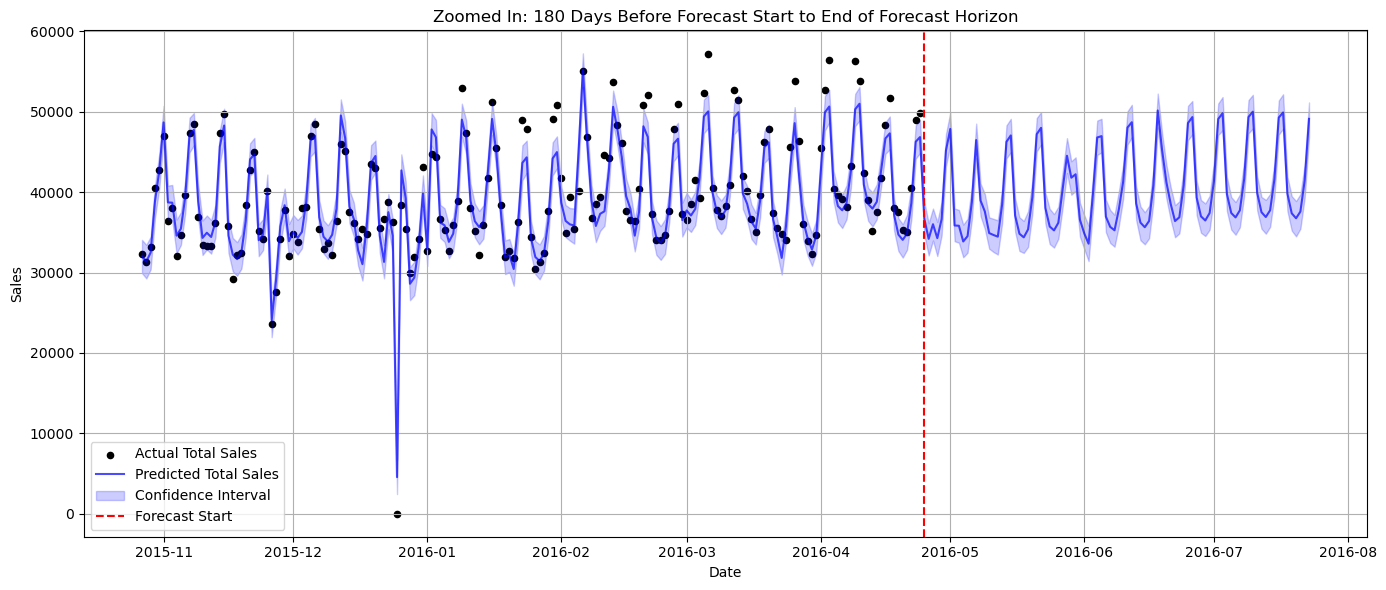

In [ ]:

# Start 180 days before last actual date
zoom_start = df["ds"].max() - pd.Timedelta(days=180)
zoom_end = forecast["ds"].max()

plot_zoom = plot_df[plot_df["ds"].between(zoom_start, zoom_end)]

plt.figure(figsize=(14, 6))

# Actual sales (black scatter)
plt.scatter(plot_zoom['ds'], plot_zoom['y'], label='Actual Total Sales', color='black', s=20)

# Predicted sales (blue line)
plt.plot(plot_zoom['ds'], plot_zoom['yhat'], label='Predicted Total Sales', color='blue', alpha=0.7)

# Confidence interval
plt.fill_between(plot_zoom['ds'], plot_zoom['yhat_lower'], plot_zoom['yhat_upper'],
                 color='blue', alpha=0.2, label='Confidence Interval')

# Red line: forecast start
plt.axvline(x=forecast_start, color='red', linestyle='--', label='Forecast Start')

# Labels and layout
plt.title('Zoomed In: 180 Days Before Forecast Start to End of Forecast Horizon')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/home/ianli/anaconda3/envs/timeseries_env/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/ianli/anaconda3/envs/timeseries_env/lib/python3.10/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/home/ianli/anaconda3/envs/timeseries_env/lib/python3.10/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing

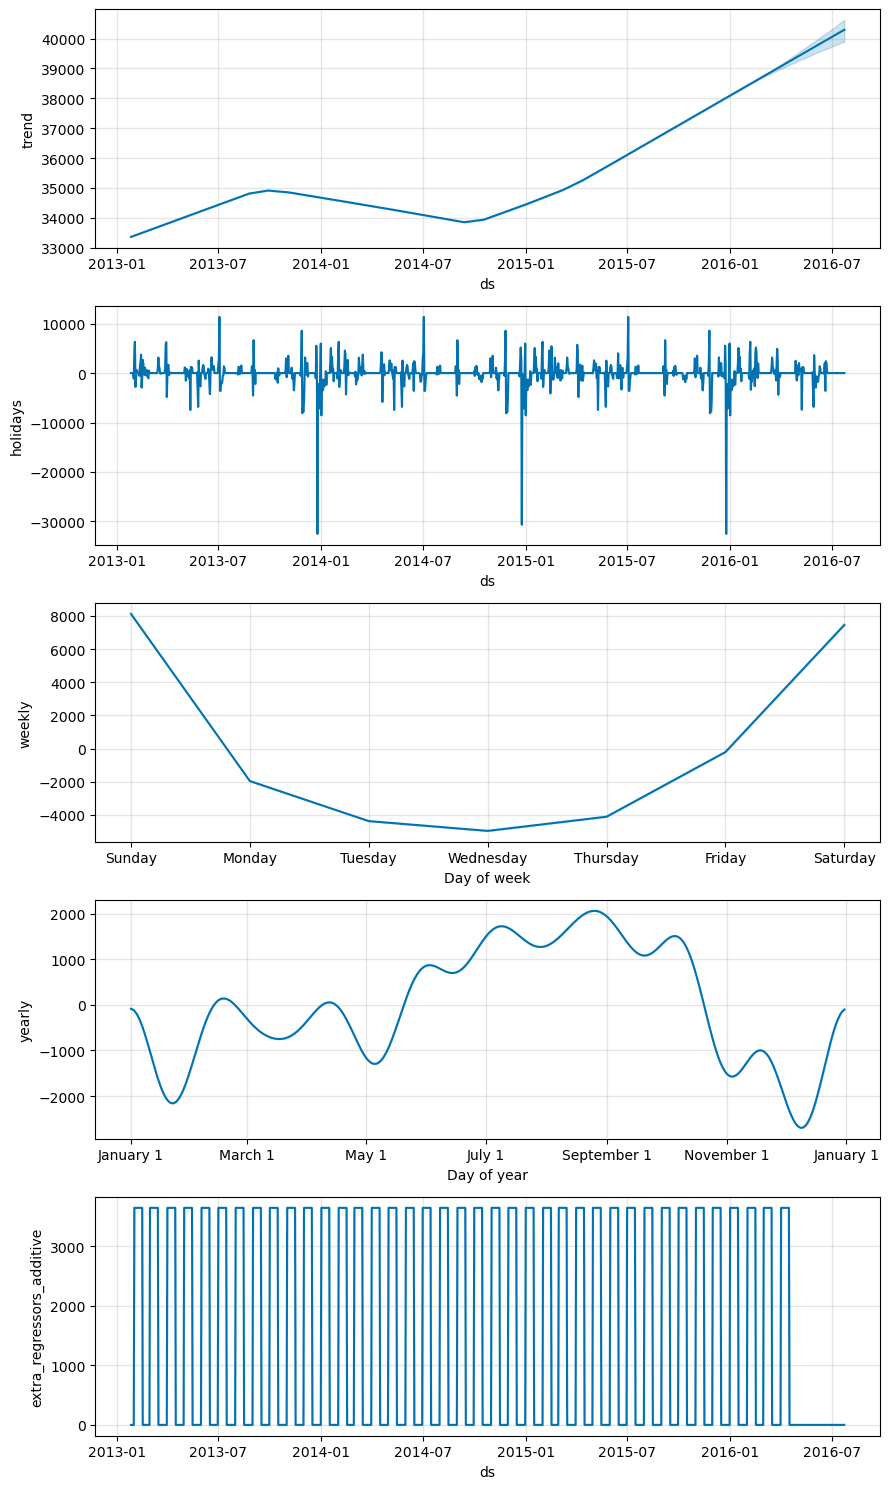

In [22]:
model.plot_components(forecast)
plt.tight_layout()
plt.show()

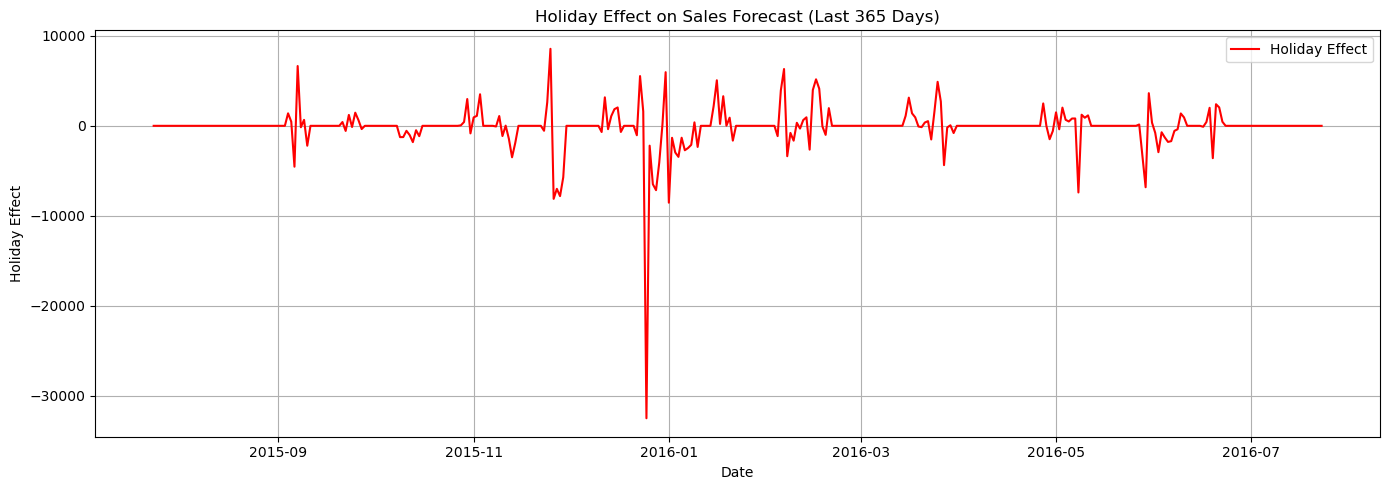

In [23]:
# Zoom to last 365 days for holiday effect
zoom_start = forecast['ds'].max() - pd.Timedelta(days=365)
holiday_zoom = forecast[forecast['ds'] >= zoom_start]

plt.figure(figsize=(14, 5))
plt.plot(holiday_zoom['ds'], holiday_zoom['holidays'], label='Holiday Effect', color='red')
plt.title("Holiday Effect on Sales Forecast (Last 365 Days)")
plt.xlabel("Date")
plt.ylabel("Holiday Effect")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

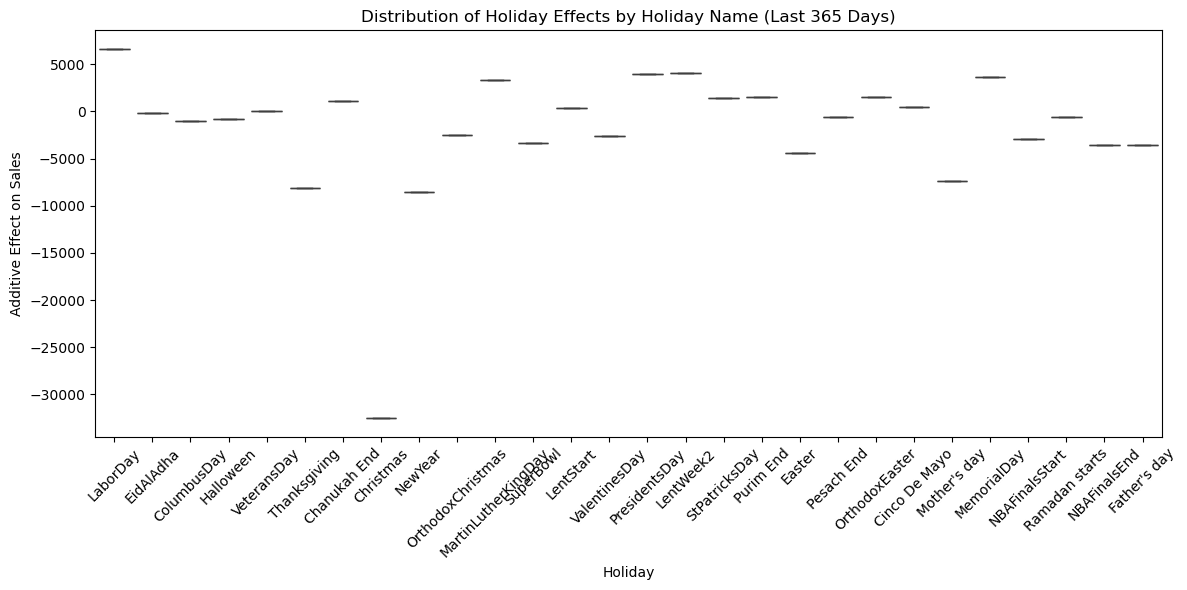

In [24]:
# Filter holidays_df to last 365 days
holidays_recent = holidays_df[holidays_df['ds'] >= zoom_start]

# Merge holiday effect with recent holidays only
holiday_effects_recent = forecast[['ds', 'holidays']].merge(
    holidays_recent[['ds', 'holiday']], on='ds', how='inner'
)

plt.figure(figsize=(12, 6))
sns.boxplot(data=holiday_effects_recent, x='holiday', y='holidays')
plt.xticks(rotation=45)
plt.title("Distribution of Holiday Effects by Holiday Name (Last 365 Days)")
plt.ylabel("Additive Effect on Sales")
plt.xlabel("Holiday")
plt.tight_layout()
plt.show()

labor day has the top positive effect on sales again

<Figure size 1400x500 with 0 Axes>

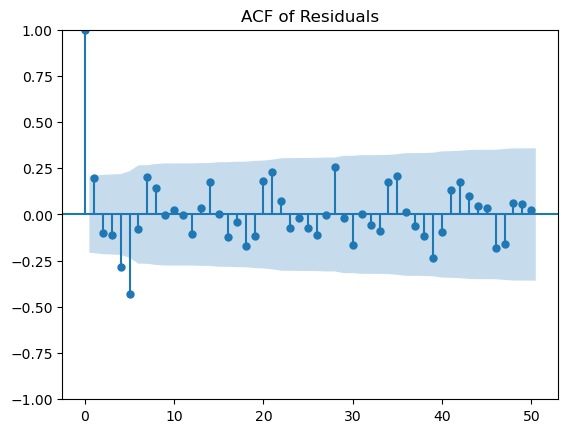

In [16]:
# Calculate residuals for the evaluation period
forecast_valid = pd.merge(forecast[['ds', 'yhat']], test[['ds', 'y']], on='ds', how='inner')
forecast_valid['residual'] = forecast_valid['y'] - forecast_valid['yhat']

plt.figure(figsize=(14,5))
plot_acf(forecast_valid['residual'], lags=50, alpha=0.05)
plt.title('ACF of Residuals')
plt.show()



In [18]:
print(len(forecast_valid['residual']))

90


<Figure size 1400x500 with 0 Axes>

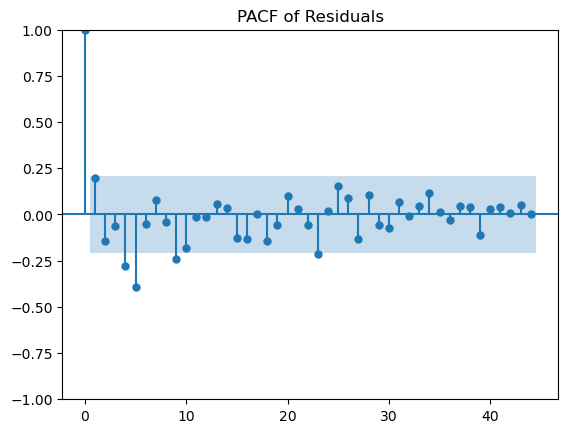

In [ ]:
max_lags = 44  # just below 45

plt.figure(figsize=(14,5))
plot_pacf(forecast_valid['residual'], lags=max_lags, alpha=0.05, method='ywm')
plt.title('PACF of Residuals')
plt.show()

Initial diagnostics showed mild residual autocorrelation at lag 4 and 5, suggesting the model underfitted some within-week patterns

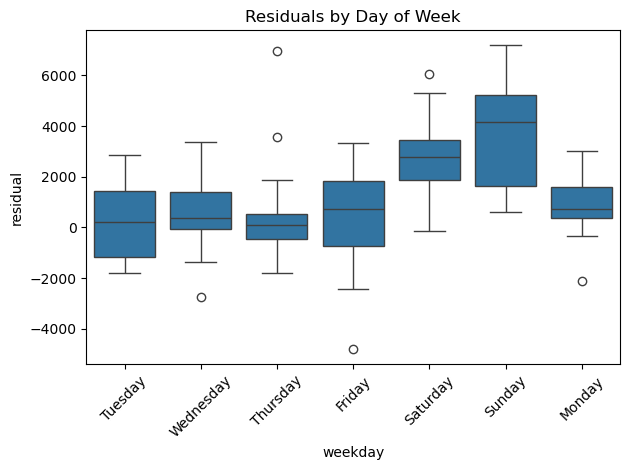

In [25]:
forecast_valid['weekday'] = forecast_valid['ds'].dt.day_name()
sns.boxplot(data=forecast_valid, x='weekday', y='residual')
plt.xticks(rotation=45)
plt.title('Residuals by Day of Week')
plt.tight_layout()
plt.show()

Residual diagnostics revealed systematic underprediction on weekends, especially Sundays. 

This indicates that Prophet’s default weekly seasonality may not fully capture weekend sales spikes.